In [24]:
import jax.numpy as np
import numpy as onp
import matplotlib.pyplot as plt
import matplotlib
font = {'size'   : 14}
matplotlib.rc('font', **font)
from jax import grad, random, jit, vmap
from functools import partial
import jax.example_libraries.optimizers as optimizers
import pickle
key = random.PRNGKey(0)

from utils import biaxial_visco, sigma_split_vmap, sigma_neoHook_vmap, init_params_nobias, init_params_positivebias, dPhi_RG_vmap, dPhi_vmap, plot45

# 1. Generate synthetic training data

In [3]:
# Neo Hookean:
mu = 77.77
K = 1.0
RG_Psi_eq_params = [K, mu]

mu = 77.77
K = 1.0
RG_Psi_neq_params = [K, mu]

eta_D = 1360
eta_V = 175000
RG_Phi_params = [np.log(eta_D), np.log(eta_V)]

RG_params = [RG_Psi_eq_params, RG_Psi_neq_params, RG_Phi_params]
RG_norm = (None, None, None)

In [4]:
lmb_x = []
lmb_y = []
sgm_x = []
sgm_y = []
time  = []
for eps_x_peak in np.linspace(-0.3,0.3,5):
    for eps_y_peak in np.linspace(-0.3,0.3,5):
        if eps_x_peak == 0 and eps_y_peak == 0:
            continue
        for t_peak in [10,20,30]:
            t_max = 100
            t = np.linspace(0,99,100)
            lm1 = np.hstack([np.linspace(1,1+eps_x_peak,t_peak), np.ones(t_max-t_peak)*(1+eps_x_peak)])
            lm2 = np.hstack([np.linspace(1,1+eps_y_peak,t_peak), np.ones(t_max-t_peak)*(1+eps_y_peak)])
            lm3 = 1/(lm1*lm2)

            sgm, lm1, lm2, lm3, lm1e, lm2e, lm3e = biaxial_visco(RG_params, RG_norm, False, t, lm1, lm2)
            lmb_x.append(lm1)
            lmb_y.append(lm2)
            sgm_x.append(sgm[:,0,0])
            sgm_y.append(sgm[:,1,1])
            time.append(t)
lmb_x = np.stack(lmb_x)
lmb_y = np.stack(lmb_y)
sgm_x = np.stack(sgm_x)
sgm_y = np.stack(sgm_y)
time = np.stack(time)

with open('training_data/RG_data.npy','wb') as f:
    np.save(f, [time, lmb_x, lmb_y, sgm_x, sgm_y])

# 2. Train Govindjee's model

In [5]:
with open('training_data/RG_data.npy','rb') as f:
    time, lmb_x, lmb_y, sgm_x, sgm_y = np.load(f)

In [6]:
def loss(params, norm, useNODE, time, lm1, lm2, sigma1, sigma2):
    sigma_pr,_,_,_,_,_,_ = biaxial_visco(params, norm, useNODE, time, lm1, lm2)
    loss = np.mean((sigma_pr[:,0,0]-sigma1)**2 + (sigma_pr[:,1,1]-sigma2)**2)
    return loss
loss_vmap = vmap(loss, in_axes=(None, None, None, 0, 0, 0, 0, 0), out_axes=0)
batch_loss = lambda params, norm, useNODE, time, lm1, lm2, sigma1, sigma2: np.mean(loss_vmap(params, norm, useNODE, time, lm1, lm2, sigma1, sigma2))

@partial(jit, static_argnums=(0,1,2,))
def step(loss_fn, norm, useNODE, i, opt_state, X1_batch, X2_batch, X3_batch, Y1_batch, Y2_batch):
    params = get_params(opt_state)
    g = grad(loss_fn, argnums=0)(params, norm, useNODE, X1_batch, X2_batch, X3_batch, Y1_batch, Y2_batch)
    return opt_update(i, g, opt_state)

def train(X1, X2, X3, Y1, Y2, norm, opt_state, key, nIter = 1000, batch_size=10):
    train_loss = []
    val_loss = []
    for it in range(nIter+1):
        key, subkey = random.split(key)
        i = random.choice(subkey, X1.shape[0], shape=(batch_size,), replace = False)
        i = tuple([i])
        opt_state = step(batch_loss, norm, False, it, opt_state, X1[i], X2[i], X3[i], Y1[i], Y2[i])
        if it % 100 == 0 or it == nIter:
            params = get_params(opt_state)
            train_loss_value = batch_loss(params, norm, False, X1[i], X2[i], X3[i], Y1[i], Y2[i])
            train_loss.append(train_loss_value)
            to_print = "it %i, train loss = %e" % (it, train_loss_value)
            print(to_print)
    return get_params(opt_state), train_loss, val_loss 

In [7]:
# Neo Hookean:
mu = 77.77 + onp.random.normal(0, 7.0)
K = 1.0 + onp.random.normal(0, 0.1)
RG_Psi_eq_params = [K, mu]

mu = 77.77 + onp.random.normal(0, 7.0)
K = 1.0 + onp.random.normal(0, 0.1)
RG_Psi_neq_params = [K, mu]

eta_D = 1360 + onp.random.normal(0, 140)
eta_V = 175000 + onp.random.normal(0, 17500)
RG_Phi_params = [np.log(eta_D), np.log(eta_V)]

RG_params = [RG_Psi_eq_params, RG_Psi_neq_params, RG_Phi_params]
RG_norm = (None, None, None)

In [8]:
# I know this is a dumb way of doing it. please don't judge me.
# for lr in [1.0e-2, 1.0e-3, 1.0e-4, 1.0e-5]:
lr = 1e-4
opt_init, opt_update, get_params = optimizers.adam(lr)
opt_state = opt_init(RG_params)
RG_params, train_loss, val_loss = train(time, lmb_x, lmb_y, sgm_x, sgm_y, RG_norm, opt_state, key, nIter = 1000, batch_size=20)
    
with open('saved/RG_params.npy', 'wb') as f:
    pickle.dump(RG_params, f)

it 0, train loss = 1.155352e+01
it 100, train loss = 1.529063e+01
it 200, train loss = 1.752366e+01
it 300, train loss = 8.058445e+00
it 400, train loss = 1.131206e+01
it 500, train loss = 1.240674e+01
it 600, train loss = 1.160008e+01
it 700, train loss = 6.018541e+00
it 800, train loss = 9.063559e+00
it 900, train loss = 1.426087e+01
it 1000, train loss = 6.619768e+00


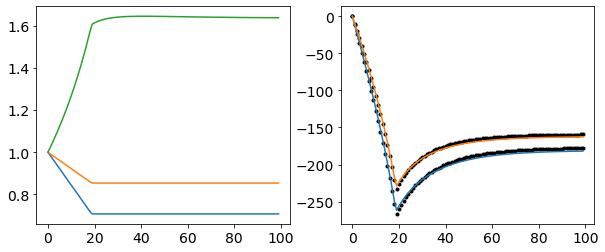

In [9]:
i=4
sigm_pr, lm1, lm2, lm3, lm1e, lm2e, lm3e = biaxial_visco(RG_params, RG_norm, False, time[i], lmb_x[i], lmb_y[i])
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].plot(time[0],lm1)
ax[0].plot(time[0],lm2)
ax[0].plot(time[0],lm3)

ax[1].plot(time[0],sgm_x[i],'k.')
ax[1].plot(time[0],sgm_y[i],'k.')
ax[1].plot(time[0],sigm_pr[:,0,0])
ax[1].plot(time[0],sigm_pr[:,1,1])

# 3. Train $\Psi_{EQ}$ and $\Psi_{NEQ}$

In [10]:
with open('saved/RG_params.npy', 'rb') as f:
    RG_params = pickle.load(f)
RG_Psi_eq_params, RG_Psi_neq_params, RG_Phi_params = RG_params

In [13]:
# Stuff common to both Psi_EQ and Psi_NEQ
layers = [1, 5, 5, 1]
def loss(params, lmb, sigma_gt):
    lm1 = lmb[:,0]
    lm2 = lmb[:,1]
    lm3 = lmb[:,2]
    sigma_pr = sigma_split_vmap(lm1, lm2, lm3, params)
    loss1 = np.average((sigma_pr[:,0,0]-sigma_gt[:,0,0])**2) 
    loss2 = np.average((sigma_pr[:,1,1]-sigma_gt[:,1,1])**2)
    loss3 = np.average((sigma_pr[:,2,2]-sigma_gt[:,2,2])**2)
    loss = (loss1+loss2+loss3)/3
    return  loss
    
@partial(jit, static_argnums=(0,))
def step(loss, i, opt_state, X_batch, Y_batch):
    params = get_params(opt_state)
    g = grad(loss)(params, X_batch, Y_batch)
    return opt_update(i, g, opt_state)

def train(loss, X, Y, opt_state, key, nIter = 10000, batch_size = 10):
    train_loss = []
    val_loss = []
    for it in range(nIter+1):
        key, subkey = random.split(key)
        idx_batch = random.choice(subkey, X.shape[0], shape = (batch_size,), replace = False)
        opt_state = step(loss, it, opt_state, X[idx_batch], Y[idx_batch])         
        if it%10000 == 0 or it == nIter:
            params = get_params(opt_state)
            train_loss_value = loss(params, X, Y)
            train_loss.append(train_loss_value)
            to_print = "it %i, train loss = %e" % (it, train_loss_value)
            print(to_print)
    return get_params(opt_state), train_loss, val_loss

# Generate inputs
lm = np.linspace(0.7,1.4,20)
lm1, lm2 = np.array(np.meshgrid(lm, lm))
lm1 = lm1.reshape(-1)
lm2 = lm2.reshape(-1)
lm3 = 1/(lm1*lm2)
lmb_1 = np.transpose(np.array([lm1, lm2, lm3]))
lmb_2 = np.transpose(np.array([lm1, lm2, lm3*0.95]))
lmb = np.vstack([lmb_1, lmb_2])

## 2.1 $\Psi_{EQ}$

In [14]:
# Initialize parameters
I1_params = init_params_nobias(layers, key)
I2_params = init_params_nobias(layers, key)
J1_params = init_params_nobias(layers, key)
alpha = 1.0
Psi1_bias = -3.0
Psi2_bias = -3.0
NN_weights = (I1_params, I2_params, J1_params)
Psi_eq_params = (NN_weights, alpha, Psi1_bias, Psi2_bias)

# Generate outputs
sigma_gt = sigma_neoHook_vmap(lmb[:,0],lmb[:,1],lmb[:,2],RG_Psi_eq_params) #since I am using the same MM for both EQ and NEQ

# Train
opt_init, opt_update, get_params = optimizers.adam(1.e-5)
opt_state = opt_init(Psi_eq_params)
Psi_eq_params, train_loss, val_loss = train(loss, lmb, sigma_gt, opt_state, key, nIter = 200000, batch_size = 10)
with open('saved/Psi_eq_params.npy', 'wb') as f:
    pickle.dump(Psi_eq_params, f)

it 0, train loss = 8.980631e+02
it 10000, train loss = 1.344015e+02
it 20000, train loss = 8.438225e+01
it 30000, train loss = 6.752240e+01
it 40000, train loss = 6.255357e+01
it 50000, train loss = 6.137316e+01
it 60000, train loss = 6.072052e+01
it 70000, train loss = 6.036331e+01
it 80000, train loss = 6.017820e+01
it 90000, train loss = 6.006888e+01
it 100000, train loss = 6.000093e+01
it 110000, train loss = 5.995149e+01
it 120000, train loss = 5.991347e+01
it 130000, train loss = 5.988299e+01
it 140000, train loss = 5.985711e+01
it 150000, train loss = 5.983542e+01
it 160000, train loss = 5.981493e+01
it 170000, train loss = 5.979770e+01
it 180000, train loss = 5.978161e+01
it 190000, train loss = 5.976662e+01
it 200000, train loss = 5.975344e+01


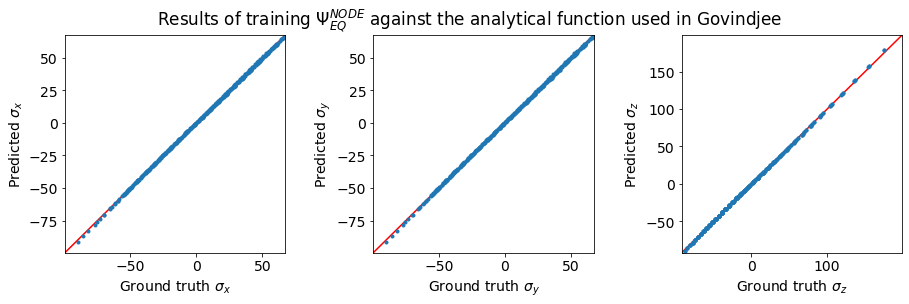

In [17]:
sigma_pr = sigma_split_vmap(lm1, lm2, lm3, Psi_eq_params)
sigma_gt = sigma_neoHook_vmap(lm1, lm2, lm3, RG_Psi_eq_params) #since I am using the same MM for both EQ and NEQ
gts = [sigma_gt[:,0,0], sigma_gt[:,1,1], sigma_gt[:,2,2]]
prs = [sigma_pr[:,0,0], sigma_pr[:,1,1], sigma_pr[:,2,2]]
labels = ['$\sigma_x$', '$\sigma_y$', '$\sigma_z$']
title = r"Results of training $\Psi_{EQ}^{NODE}$ against the analytical function used in Govindjee"
plot45(gts, prs, labels, title)

## 1.2 $\Psi_{NEQ}$

In [18]:
# Initialize parameters
I1_params = init_params_nobias(layers, key)
I2_params = init_params_nobias(layers, key)
J1_params = init_params_nobias(layers, key)
alpha = 1.0
Psi1_bias = -3.0
Psi2_bias = -3.0
NN_weights = (I1_params, I2_params, J1_params)
Psi_neq_params = (NN_weights, alpha, Psi1_bias, Psi2_bias)

# Generate outputs
# sigma_gt = sigma_Ogden_vmap(lmb[:,0],lmb[:,1],lmb[:,2],RG_Psi_neq_params)
sigma_gt = sigma_neoHook_vmap(lmb[:,0],lmb[:,1],lmb[:,2],RG_Psi_neq_params)

opt_init, opt_update, get_params = optimizers.adam(1.e-4)
opt_state = opt_init(Psi_neq_params)
Psi_neq_params, train_loss, val_loss = train(loss, lmb, sigma_gt, opt_state, key, nIter = 100000, batch_size = 10)
with open('saved/Psi_neq_params.npy', 'wb') as f:
    pickle.dump(Psi_neq_params, f)

it 0, train loss = 9.386188e+02
it 10000, train loss = 4.681298e+02
it 20000, train loss = 4.336976e+02
it 30000, train loss = 4.237592e+02
it 40000, train loss = 4.211102e+02
it 50000, train loss = 4.203493e+02
it 60000, train loss = 4.199646e+02
it 70000, train loss = 4.197729e+02
it 80000, train loss = 4.196727e+02
it 90000, train loss = 4.196076e+02
it 100000, train loss = 4.195633e+02


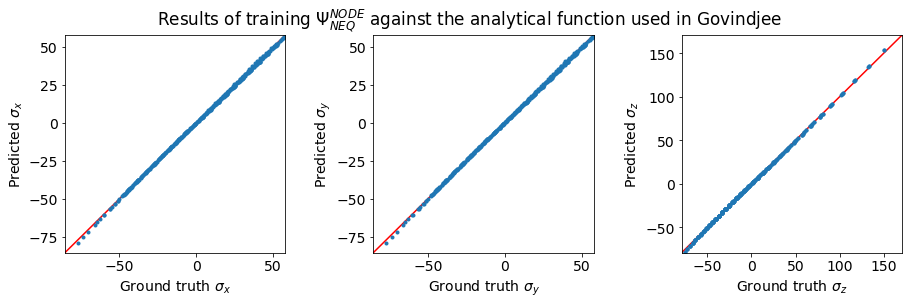

In [19]:
sigma_pr = sigma_split_vmap(lm1, lm2, lm3, Psi_neq_params)
# sigma_gt = sigma_Ogden_vmap(lm1, lm2, lm3, RG_Psi_neq_params)
sigma_gt = sigma_neoHook_vmap(lm1, lm2, lm3, RG_Psi_neq_params)
gts = [sigma_gt[:,0,0], sigma_gt[:,1,1], sigma_gt[:,2,2]]
prs = [sigma_pr[:,0,0], sigma_pr[:,1,1], sigma_pr[:,2,2]]
labels = ['$\sigma_x$', '$\sigma_y$', '$\sigma_z$']
title = r"Results of training $\Psi_{NEQ}^{NODE}$ against the analytical function used in Govindjee"
plot45(gts, prs, labels, title)

# 4. Train $\Phi^{NODE}$ with $\Phi^{Govindjee}$

In [22]:
with open('saved/RG_params.npy', 'rb') as f:
    RG_params = pickle.load(f)
RG_Psi_eq_params, RG_Psi_neq_params, RG_Phi_params = RG_params
eta_D, eta_V = RG_Phi_params

In [34]:
# Generate training data
# Input data and normalization factors
taui = onp.mgrid[-200:200:10j, -200:200:10j, -200:200:10j]
taui = taui.reshape([3,-1]).transpose()
taui = -onp.sort(-taui)

tau1 = taui[:,0]
tau2 = taui[:,1]
tau3 = taui[:,2]
I12     = tau1**2 + tau2**2 + tau3**2 + 2*tau1*tau2 + 2*tau1*tau3 + 2*tau2*tau3
I12m3I2 = tau1**2 + tau2**2 + tau3**2 -   tau1*tau2 -   tau1*tau3 -   tau2*tau3

inp_std1 = onp.std(tau1)
inp_std2 = onp.std(tau1 + tau2)
inp_std3 = onp.std(tau1 + tau2 + tau3)
inp_std4 = onp.std(I12)
inp_std5 = onp.std(I12m3I2)
inp_stds = (inp_std3, inp_std4, inp_std5)

out_std1 = 1.0
out_std2 = 1.0
out_std3 = 1.0
out_std4 = 1/9/175000
out_std5 = 1/3/1360
out_stds = (out_std3, out_std4, out_std5)
Phi_norm = (inp_stds, out_stds)

# Output data
dphidtaui = onp.array(dPhi_RG_vmap([taui[:,0], taui[:,1], taui[:,2]], eta_D, eta_V)).transpose()

In [27]:
# Initialize NN weights
layers = [1,2,3,1]
NODE3_params = init_params_positivebias(layers, key)
NODE4_params = init_params_positivebias(layers, key)
NODE5_params = init_params_positivebias(layers, key)
Phi_params = [NODE3_params, NODE4_params, NODE5_params]

# Train
def loss(params, norm, taui, dphidtaui_gt):
    tau1, tau2, tau3 = taui.transpose()
    dphidtaui_pr = dPhi_vmap([tau1, tau2, tau3], params, norm)
    loss = np.average((dphidtaui_pr[0]-dphidtaui_gt[:,0])**2)
    loss+= np.average((dphidtaui_pr[1]-dphidtaui_gt[:,1])**2)
    loss+= np.average((dphidtaui_pr[2]-dphidtaui_gt[:,2])**2)
    return loss
@partial(jit, static_argnums=(0,1,))
def step(loss, norm, i, opt_state, X_batch, Y_batch):
    params = get_params(opt_state)
    g = grad(loss)(params, norm, X_batch, Y_batch)
    return opt_update(i, g, opt_state)
def train(loss, X, Y, norm, opt_state, key, nIter = 5000, batch_size = 100):
    global best_params
    train_loss = []
    for it in range(nIter+1):
        key, subkey = random.split(key)
        idx_batch = random.choice(subkey, X.shape[0], shape = (batch_size,), replace = False)
        opt_state = step(loss, norm, it, opt_state, X[idx_batch], Y[idx_batch])
        if it % 10000 == 0 or it == nIter:
            params = get_params(opt_state)
            train_loss_value = loss(params, norm, X, Y)
            train_loss.append(train_loss_value)
            to_print = "it %i, train loss = %e" % (it, train_loss_value)
            print(to_print)
    return get_params(opt_state), train_loss

opt_init, opt_update, get_params = optimizers.adam(1.e-4)
opt_state = opt_init(Phi_params)
Phi_params, train_loss = train(loss, taui, dphidtaui, Phi_norm, opt_state, key, nIter=200000)

with open('saved/Phi_params.npy', 'wb') as f:
    pickle.dump(Phi_params, f)
with open('saved/Phi_norm_w.npy', 'wb') as f:
    pickle.dump(Phi_norm, f)

it 0, train loss = 7.554363e+00
it 10000, train loss = 6.327830e-02
it 20000, train loss = 3.332872e-03
it 30000, train loss = 6.677448e-04
it 40000, train loss = 2.074874e-04
it 50000, train loss = 7.699171e-05
it 60000, train loss = 3.220315e-05
it 70000, train loss = 1.491087e-05
it 80000, train loss = 7.773019e-06
it 90000, train loss = 4.390924e-06
it 100000, train loss = 2.713560e-06
it 110000, train loss = 1.761841e-06
it 120000, train loss = 1.217091e-06
it 130000, train loss = 8.822609e-07
it 140000, train loss = 6.729805e-07
it 150000, train loss = 5.137467e-07
it 160000, train loss = 4.160314e-07
it 170000, train loss = 3.324149e-07
it 180000, train loss = 2.812167e-07
it 190000, train loss = 2.278631e-07
it 200000, train loss = 1.955521e-07


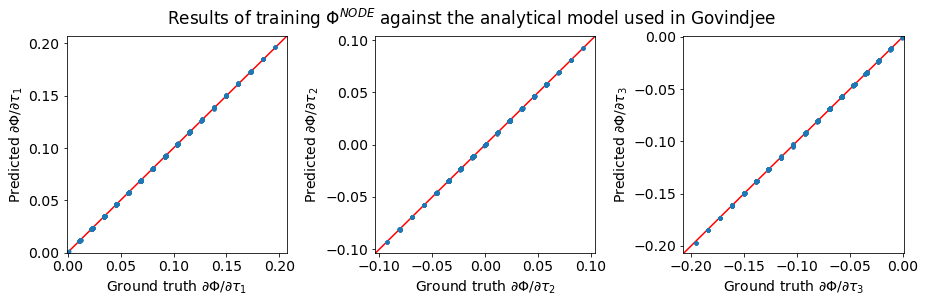

In [30]:
prs = dPhi_vmap([taui[:,0], taui[:,1], taui[:,2]], Phi_params, Phi_norm)
gts = dPhi_RG_vmap([taui[:,0], taui[:,1], taui[:,2]], eta_D, eta_V)

labels = ['$\partial \Phi / \partial \\tau_1$', '$\partial \Phi / \partial \\tau_2$', '$\partial \Phi / \partial \\tau_3$']
title = r"Results of training $\Phi^{NODE}$ against the analytical model used in Govindjee"
plot45(gts, prs, labels, title)

# 5. Test

In [36]:
#Load the pre-trained parameters
with open('saved/Psi_eq_params.npy', 'rb') as f:
    Psi_eq_params = pickle.load(f)
with open('saved/Psi_neq_params.npy', 'rb') as f:
    Psi_neq_params = pickle.load(f)
with open('saved/Phi_params.npy', 'rb') as f:
    Phi_params = pickle.load(f)
with open('saved/Phi_norm_w.npy', 'rb') as f:
    Phi_norm = pickle.load(f)
params = (Psi_eq_params, Psi_neq_params, Phi_params)
norm = (None, None, Phi_norm)

with open('saved/RG_params.npy', 'rb') as f:
    RG_params = pickle.load(f)

with open('training_data/RG_data.npy','rb') as f:
    time, lmb_x, lmb_y, sgm_x, sgm_y = np.load(f)

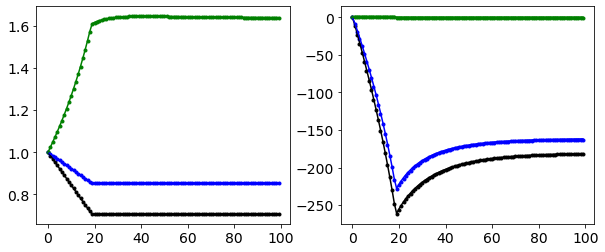

In [37]:
i=4
t = time[0]
sig_NN, lm1_NN, lm2_NN, lm3_NN, lm1e_NN, lm2e_NN, lm3e_NN  = biaxial_visco(params,     norm,     True,  t, lmb_x[i],lmb_y[i])
sig_RG,lm1_RG,lm2_RG,lm3_RG,lm1e_RG,lm2e_RG,lm3e_RG = biaxial_visco(RG_params, RG_norm, False, t, lmb_x[i],lmb_y[i])

t = np.linspace(0, t[-1], sig_NN.shape[0])

fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(t,lm1_RG, 'k.')
ax[0].plot(t,lm2_RG, 'b.')
ax[0].plot(t,lm3_RG, 'g.')
ax[0].plot(t,lm1_NN, 'k-')
ax[0].plot(t,lm2_NN, 'b-')
ax[0].plot(t,lm3_NN, 'g-')

ax[1].plot(t,sig_RG[:,0,0],'k.')
ax[1].plot(t,sig_RG[:,1,1],'b.')
ax[1].plot(t,sig_RG[:,2,2],'g.')
ax[1].plot(t,sig_NN[:,0,0],'k-')
ax[1].plot(t,sig_NN[:,1,1],'b-')
ax[1].plot(t,sig_NN[:,2,2],'g-')